# Import Section
---

In [78]:
from pyocd.core.helpers import ConnectHelper
from pyocd.flash.file_programmer import FileProgrammer
from pyocd.core.memory_map import MemoryType
from pyocd.coresight.cortex_m import CortexM

import logging
#logging.basicConfig(level=logging.INFO)

import numpy as np
import time as tt
import math
import os

# MCU Record Section
---
- This part is the function that record your voice by mcu's microphone.
- The `*.bin` file is the mcu's running code for recording.
- The setting is total 7s to record.
- You can comment out `FileProgrammer(session).program("I2S_Codec_PDMA_SCA_max.bin")` after first time record for saving time and not flash every time recording.

In [79]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


class m460_record:
    
    def __init__(self):
        self.BUFF_LEN = 64000  # 4*16000
        self.Byte_len = 4
        self.sram_begain = 0x20000038 #s_au32PcmTxBuff
        #self.sram_begain = 0x200001b0
        
    def recording(self):

        with ConnectHelper.session_with_chosen_probe(target_override="m467hjhae") as session:
        
            board = session.board
            target = board.target
            flash = target.memory_map.get_boot_memory()
        
            FileProgrammer(session).program("I2S_Codec_PDMA_SCA_max.bin")
            
            
            target.reset(reset_type = target.ResetType.SW)
            print('Start to record 7s')
            
            tt.sleep(8)
            print('The record is finished, waiting for pulling data from board ...')
            
            #target.halt()
            
            #Depend on I2S_Codec_PDMA setting
            #BUFF_LEN = 64000  # 4*16000
            #Byte_len = 4
            #sram_begain = 0x20000034 #s_au32PcmTxBuff
            
            st = tt.time()
            
            pmf32 = target.read_memory_block32(self.sram_begain, self.BUFF_LEN)
            
            ed = tt.time()
            print("Total pulling time: {}".format((ed - st)))
            print("Data size (Bytes): {}".format(len(pmf32)))
            
            return pmf32 #return the sound array
    

# Transfer PCM data to WAV data
---
- This part is PCM data processing
- Detail:
         1. crop the default noise at first second.
         2. amplified the the wav data(optional, basing on bsp bin file).
         3. transfer from int32 to int16 (KWS is using int16).

In [95]:
import wave
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import time

class PCM_WAV_pro:

    def __init__(self, amp, folder):
        self.amp = amp
        self.folder = folder #default exist folder
        self.create_tag_folder(self.folder)
        _time = (str)(math.ceil(time.time()))
        self.filename = _time + '_nohash'  #The filename is time, so it is unique
        self.filepath = self.folder + '\\' + self.filename
    
    def create_tag_folder(self, tag_name):
        dir_path = os.path.join(os.getcwd(), tag_name)
        try:
            os.mkdir(dir_path)
        except OSError as error:
            #print(error)
            print('skip create folder')
        #print(os.getcwd())
    
    def delete_32b(self):
        os.remove(self.filepath + "_int32.wav")
    
    def trans_16b(self):
        rate, data = read(self.filepath + "_int32.wav")
        #print("Sample rate: {} Hz".format(rate))
        #print("Data type: {}".format(data.dtype))
        
        write(self.filepath+".wav", 16000, data.astype(np.int16)) ##transfer from int32 to int16
        rate_16, data_16 = read(self.filepath+".wav")
        
        time = np.arange(0, len(data)) / rate
        plt.figure(figsize=(15, 5))
        
        plotA = plt.subplot(211)
        plotA.plot(time, data)
        plotA.set_ylabel("Amplitude")
        plotA.set_xlim(0, len(data) / rate)
        
        plotB = plt.subplot(212)
        plotB.plot(time, data_16)
        plotB.set_ylabel("Amplitude")
        plotB.set_xlim(0, len(data) / rate)
    
    def pcm2wav(self, pcmdata, wav_file, channels=1, bits=32, sample_rate= 16000):
     
        wavfile = wave.open(wav_file, 'wb')
        wavfile.setnchannels(channels)
        wavfile.setsampwidth(bits // 8)
        wavfile.setframerate(sample_rate)
        wavfile.writeframes(pcmdata)
        wavfile.close()
    
    def trans_wavFile(self, pmf32):
        arr = np.array(pmf32)
        arr_amp = arr * self.amp
        #self.pcm2wav(arr[:], self.filepath + "_raw.wav")
        self.pcm2wav(arr_amp[8000:], self.filepath + "_int32.wav")
        



# Run Section
---
- The record file is save in `/raw` folder
- (recommend)(will update) Collect all same label recording files at same folder and copy/move to `/ML_audio_aq`

128000
60526
61164
skip create folder


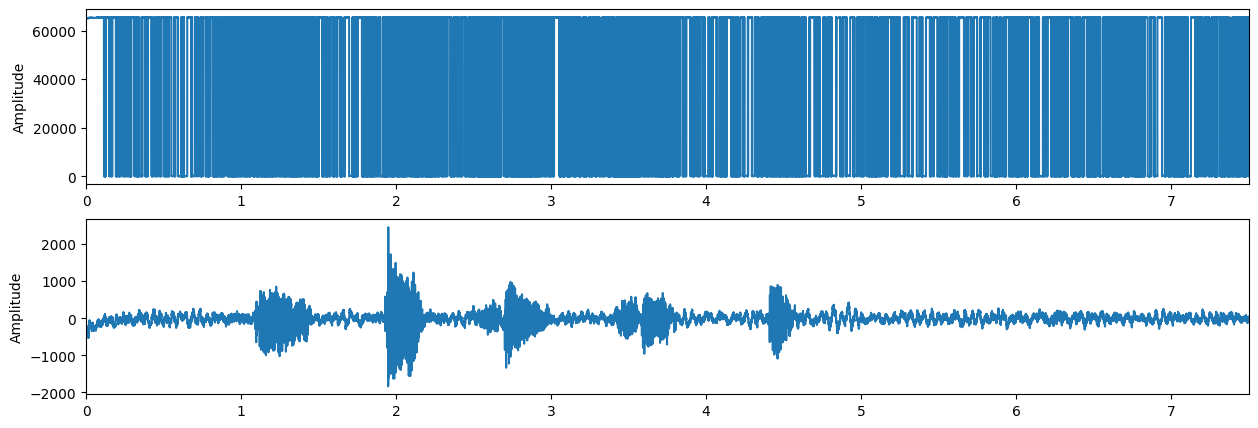

In [103]:
rd_m = m460_record()
pcm = rd_m.recording()

# Convert the 1 channel 32bits data(carry N(16bits) & N+1(16bits)) to N & N+1 data
pcm_buf_int32 = pcm

pcm_buf_int16 = []
for x in pcm_buf_int32:
    #s_pcm.append( x >> 16)
    pcm_buf_int16.append( x & 0x0000FFFF)
    pcm_buf_int16.append( ((x & 0xFFFF0000)>>16))

trans = PCM_WAV_pro(1, 'raw1')
trans.trans_wavFile(pcm_buf_int16)

trans.trans_16b() #transfer to 16bits
trans.delete_32b() #delete no use file

# Looping Record (Optional)
---
- This block help to record keyword more quickly. 
- It will continue `looping_num` times to record, and each time is same as 7 (s).
- Please update `looping_num` to decide how many time you want.

Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.163476228713989
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.083132982254028
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.157998323440552
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.1344709396362305
Data size (Bytes): 64000
Start to record 8s
The record is finished, waiting for pulling data from board ...
Total pulling time: 4.126887321472168
Data size (Bytes): 64000


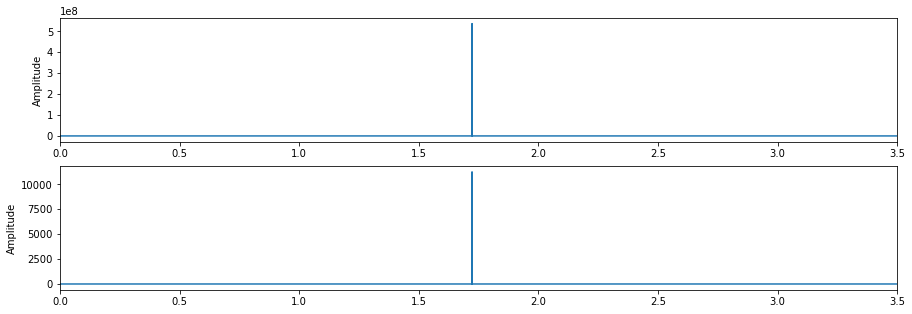

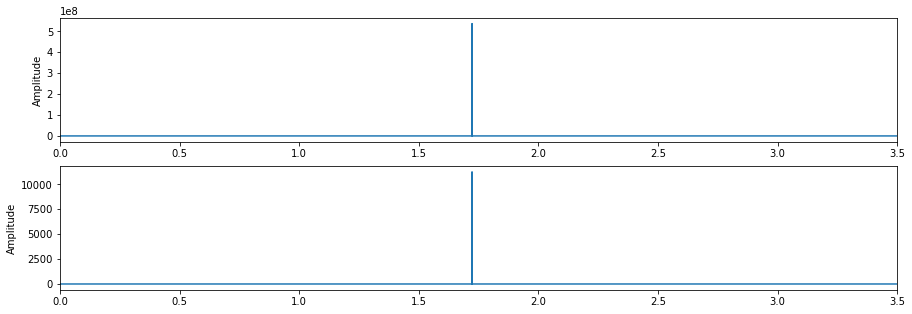

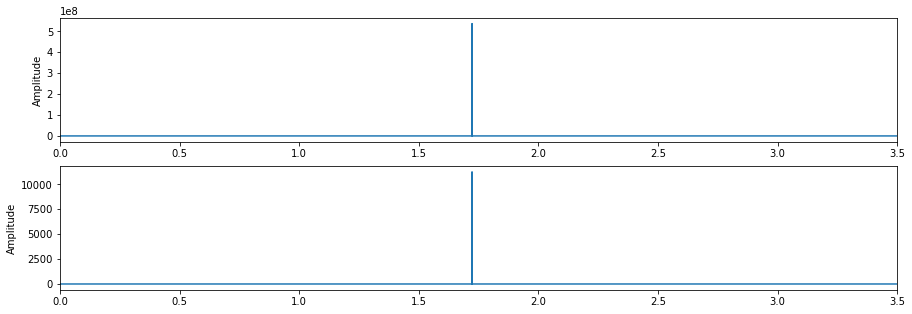

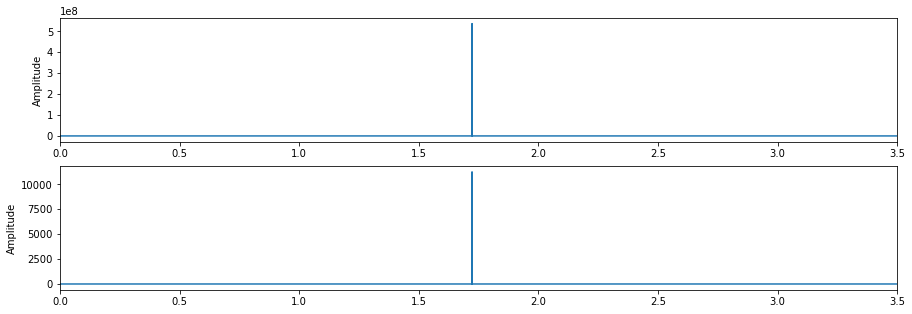

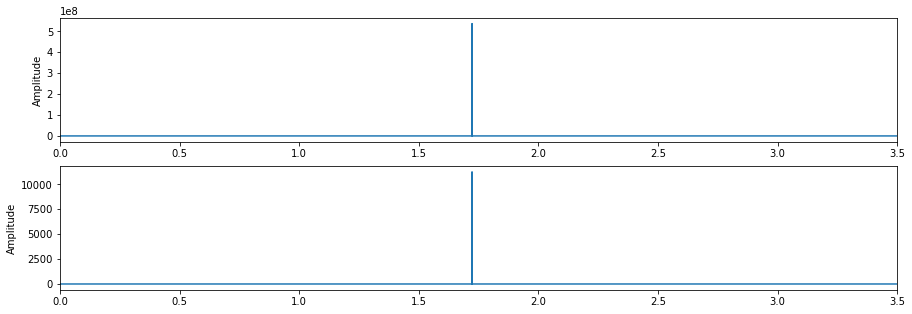

In [5]:
looping_num = 5

for i in range(0, looping_num):
    rd_m = m460_record()
    pcm = rd_m.recording()
    
    
    trans = PCM_WAV_pro(1, 'raw')
    trans.trans_wavFile(pcm)
    
    trans.trans_16b() #transfer to 16bits
    trans.delete_32b() #delete no use file

# Alternative way to pull and save the SRAM data (No Need)
---
- savemem command to bin file and readback the pmf array 

In [6]:
st = time.time()
!pyocd commander -t M467HJHAE -c "savemem 0x20000030 0x0000fa00 dump.bin"
ed = time.time()
print(ed - st)

import struct
import numpy as np

with open('dump.bin') as f:
    rectype = np.dtype(np.uint32)
    bdata = np.fromfile(f, dtype=rectype)

print(len(bdata))

Saved 64000 bytes to dump.bin
3.002626895904541
16000
